In [20]:
!pip install pandas scikit-learn sentence-transformers transformers tensorflow tensorflow-hub gensim torch xgboost openai==0.28.0 tqdm

In [21]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# For embeddings
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, AlbertTokenizer, AlbertModel, TFBertForSequenceClassification
import tensorflow_hub as hub
import openai
import gensim
import torch

# For Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Embedding, Flatten


In [22]:
df=pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [23]:
# X = df['URL'].values  # Select URL column
# y = df['label'].values


In [24]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# def get_sbert_embeddings(texts):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)
#     return embeddings

In [26]:
#Generate training embeddings
# embeddings_dict = {}

In [27]:
# SBERT
# print("Generating SBERT embeddings...")
# embeddings_dict['SBERT'] = get_sbert_embeddings(X_train)
# embeddings_dict['SBERT'].shape

In [28]:
#Generate test embeddings
# test_embeddings_dict = {}

In [29]:
# SBERT
# print("Generating SBERT test embeddings...")
# test_embeddings_dict['SBERT'] = get_sbert_embeddings(X_test)
# test_embeddings_dict['SBERT'].shape

In [38]:
#Load Embeddings
with open('embeddings_dict.pkl', 'rb') as f:
  embeddings_dict = pickle.load(f)

with open('test_embeddings_dict.pkl', 'rb') as f:
  test_embeddings_dict = pickle.load(f)

#Load manual scaled features
with open('X_train_manual_scaled.pkl', 'rb') as f:
  X_train_manual_scaled = pickle.load(f)

with open('X_test_manual_scaled.pkl', 'rb') as f:
  X_test_manual_scaled = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
  y_train= pickle.load(f)

with open('y_test.pkl', 'rb') as f:
  y_test= pickle.load(f)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout, InputLayer

def build_ffnn(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),  # Explicit Input layer
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [40]:
def build_rnn(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        SimpleRNN(128, activation='tanh'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [41]:
def build_lstm(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        LSTM(128),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [42]:
def build_cnn(input_dim, timesteps=1):
    model = Sequential([
        InputLayer(input_shape=(timesteps, input_dim)),
        Conv1D(128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [43]:
import os
def create_model_dir(base_dir='saved_models', embedding='SBERT', model_type='FFNN'):
    path = os.path.join(base_dir, embedding, model_type)
    os.makedirs(path, exist_ok=True)
    return path

In [47]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.5 MB/s eta 0:00:00a 0:00:01


In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from matplotlib import pyplot as plt

# Define a custom callback to compute F1-Score at the end of each epoch
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_target = self.validation_data[1]
        _val_f1 = f1_score(val_target, val_predict)
        self.f1_scores.append(_val_f1)
        logs['val_f1'] = _val_f1
        print(f" — val_f1: {_val_f1:.4f}")

# Function to plot and save graphs
def plot_and_save(history, f1_callback, model_dir, model_name, emb):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure()
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title(f'{model_name} with {emb} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    loss_path = os.path.join(model_dir, 'loss.png')
    plt.savefig(loss_path)
    plt.close()

    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.figure()
        plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
        plt.title(f'{model_name} with {emb} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        acc_path = os.path.join(model_dir, 'accuracy.png')
        plt.savefig(acc_path)
        plt.close()

    # Plot F1-Score
    plt.figure()
    plt.plot(epochs, f1_callback.f1_scores, 'bo-', label='Validation F1-Score')
    plt.title(f'{model_name} with {emb} - F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    f1_path = os.path.join(model_dir, 'f1_score.png')
    plt.savefig(f1_path)
    plt.close()

Matplotlib is building the font cache; this may take a moment.


In [49]:

# Define list of models
model_builders = {
    'FFNN': build_ffnn,
    'RNN': build_rnn,
    'LSTM': build_lstm,
    # 'CNN': build_cnn
}

# Define embedding types
# embedding_types = ['SBERT', 'BERT-CLS', 'USE', 'FastText', 'RoBERTa', 'ALBERT']

# Initialize results storage
results = []

# Early Stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Iterate through each embedding type
for emb in embeddings_dict.keys():
    print(f"\nProcessing Embedding: {emb}")

    X_train_emb = embeddings_dict[emb]
    X_test_emb = test_embeddings_dict[emb]

    # Concatenate with manual features
    # X_train_combined = np.hstack((X_train_emb, X_train_manual_scaled))
    # X_test_combined = np.hstack((X_test_emb, X_test_manual_scaled))
    X_train_combined = X_train_emb
    X_test_combined = X_test_emb
    # Get input dimension
    input_dim = X_train_combined.shape[1]

    # For RNN, LSTM, CNN: reshape to (samples, timesteps, features)
    X_train_rnn = X_train_combined.reshape((X_train_combined.shape[0], 1, X_train_combined.shape[1]))
    X_test_rnn = X_test_combined.reshape((X_test_combined.shape[0], 1, X_test_combined.shape[1]))

    # Iterate through each model
    for model_name, builder in model_builders.items():
        print(f"Training Model: {model_name} with Embedding: {emb}")

        # Select input based on model type
        if model_name in ['RNN', 'LSTM', 'CNN']:
            X_train_input = X_train_rnn
            X_test_input = X_test_rnn
            model_input_dim = X_train_combined.shape[1]
            timesteps = 1
        else:
            X_train_input = X_train_combined
            X_test_input = X_test_combined
            model_input_dim = input_dim
            timesteps = None  # Not needed for FFNN

        # Build model
        if model_name == 'FFNN':
            model = builder(model_input_dim)
        elif model_name == 'RNN':
            model = builder(model_input_dim, timesteps=1)
        elif model_name == 'LSTM':
            model = builder(model_input_dim, timesteps=1)
        elif model_name == 'CNN':
            model = builder(model_input_dim, timesteps=1)
        else:
            raise ValueError(f"Unknown model type: {model_name}")

        # Define directory and checkpoint path
        model_dir = create_model_dir(embedding=emb, model_type=model_name)
        checkpoint_path = os.path.join(model_dir, 'best_model.keras')

        # Define callbacks
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',      # You can change this to 'val_accuracy' or another metric
            verbose=1,
            save_best_only=True,
            mode='min'               # Use 'max' if monitoring metrics like accuracy
        )
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        # Initialize F1 callback
        f1_callback = F1ScoreCallback(validation_data=(X_test_input, y_test))

        # Train model with callbacks
        history = model.fit(
            X_train_input, y_train,
            epochs=50,                        # Increased epochs to allow convergence
            batch_size=32,
            validation_split=0.1,
            callbacks=[checkpoint, early_stop, f1_callback],
            verbose=1
        )

        # Plot and save the graphs
        plot_and_save(history, f1_callback, model_dir, model_name, emb)

        # Evaluate model
        y_pred_prob = model.predict(X_test_input).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        acc = np.mean(y_pred == y_test)
        f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
        auc = roc_auc_score(y_test, y_pred_prob)

        # Store results
        results.append({
            'Embedding': emb,
            'Model': model_name,
            'Accuracy': acc,
            'F1-Score': f1,
            'ROC-AUC': auc
        })

        print(f"Model: {model_name}, Embedding: {emb}, Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {auc:.4f}")



Processing Embedding: SBERT
Training Model: FFNN with Embedding: SBERT


/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1393
Epoch 1: val_loss improved from inf to 0.05084, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step
 — val_f1: 0.9878
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9440 - loss: 0.1393 - val_accuracy: 0.9856 - val_loss: 0.0508 - val_f1: 0.9878
Epoch 2/50
5302/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0489
Epoch 2: val_loss improved from 0.05084 to 0.04146, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step
 — val_f1: 0.9901
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9852 - loss: 0.0489 - val_accuracy: 0.9888 - val_loss: 0.0415 - val_f1: 0.9901
Epoch 3/50
5280/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0401
Epoch 3: val_loss improved from 0.04146 to 0.03577, saving model to saved_models/SBERT/FFNN/best_model.keras
1474/1474 ━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5248/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.9307 - loss: 0.1732
Epoch 1: val_loss improved from inf to 0.05395, saving model to saved_models/SBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step
 — val_f1: 0.9861
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 6s 927us/step - accuracy: 0.9310 - loss: 0.1725 - val_accuracy: 0.9823 - val_loss: 0.0539 - val_f1: 0.9861
Epoch 2/50
5252/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.9817 - loss: 0.0595
Epoch 2: val_loss did not improve from 0.05395
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step
 — val_f1: 0.9859
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 5s 901us/step - accuracy: 0.9817 - loss: 0.0595 - val_accuracy: 0.9831 - val_loss: 0.0550 - val_f1: 0.9859
Epoch 3/50
5260/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9853 - loss: 0.0501
Epoch 3: val_loss improved from 0.05395 to 0.04427, saving model to saved_models/SBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
 — val_f1: 0.9888
5306/5306 ━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5296/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9325 - loss: 0.1697
Epoch 1: val_loss improved from inf to 0.05600, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step
 — val_f1: 0.9846
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9325 - loss: 0.1695 - val_accuracy: 0.9816 - val_loss: 0.0560 - val_f1: 0.9846
Epoch 2/50
5290/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0588
Epoch 2: val_loss improved from 0.05600 to 0.04233, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step
 — val_f1: 0.9896
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9816 - loss: 0.0588 - val_accuracy: 0.9873 - val_loss: 0.0423 - val_f1: 0.9896
Epoch 3/50
5287/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0444
Epoch 3: val_loss improved from 0.04233 to 0.03905, saving model to saved_models/SBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9567 - loss: 0.1119
Epoch 1: val_loss improved from inf to 0.03028, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step
 — val_f1: 0.9935
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9568 - loss: 0.1118 - val_accuracy: 0.9927 - val_loss: 0.0303 - val_f1: 0.9935
Epoch 2/50
5303/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0458
Epoch 2: val_loss improved from 0.03028 to 0.02111, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step
 — val_f1: 0.9960
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9876 - loss: 0.0458 - val_accuracy: 0.9950 - val_loss: 0.0211 - val_f1: 0.9960
Epoch 3/50
5294/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9906 - loss: 0.0386
Epoch 3: val_loss improved from 0.02111 to 0.01846, saving model to saved_models/BERT_CLS/FFNN/best_model.keras
1474

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5289/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9626 - loss: 0.0977
Epoch 1: val_loss improved from inf to 0.02191, saving model to saved_models/BERT_CLS/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
 — val_f1: 0.9956
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9627 - loss: 0.0975 - val_accuracy: 0.9944 - val_loss: 0.0219 - val_f1: 0.9956
Epoch 2/50
5290/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9924 - loss: 0.0303
Epoch 2: val_loss did not improve from 0.02191
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step
 — val_f1: 0.9934
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9924 - loss: 0.0303 - val_accuracy: 0.9917 - val_loss: 0.0350 - val_f1: 0.9934
Epoch 3/50
5275/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9940 - loss: 0.0249
Epoch 3: val_loss improved from 0.02191 to 0.02097, saving model to saved_models/BERT_CLS/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step
 — val_f1: 0.9961
5306/5306 

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9704 - loss: 0.0828
Epoch 1: val_loss improved from inf to 0.02408, saving model to saved_models/BERT_CLS/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step
 — val_f1: 0.9955
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9705 - loss: 0.0828 - val_accuracy: 0.9945 - val_loss: 0.0241 - val_f1: 0.9955
Epoch 2/50
5292/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0286
Epoch 2: val_loss improved from 0.02408 to 0.02210, saving model to saved_models/BERT_CLS/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step
 — val_f1: 0.9961
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9929 - loss: 0.0286 - val_accuracy: 0.9950 - val_loss: 0.0221 - val_f1: 0.9961
Epoch 3/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0276
Epoch 3: val_loss improved from 0.02210 to 0.01804, saving model to saved_models/BERT_CLS/LSTM/best_model.keras
1474

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5721 - loss: 0.6845
Epoch 1: val_loss improved from inf to 0.68383, saving model to saved_models/USE/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.5721 - loss: 0.6845 - val_accuracy: 0.5701 - val_loss: 0.6838 - val_f1: 0.7277
Epoch 2/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5709 - loss: 0.6834
Epoch 2: val_loss improved from 0.68383 to 0.68334, saving model to saved_models/USE/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.5709 - loss: 0.6834 - val_accuracy: 0.5701 - val_loss: 0.6833 - val_f1: 0.7277
Epoch 3/50
5295/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5709 - loss: 0.6833
Epoch 3: val_loss improved from 0.68334 to 0.68328, saving model to saved_models/USE/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Model: FFNN, Embedding: USE, Accuracy: 0.5719, F1-Score: 0.7277, ROC-AUC: 0.5000
Training Model: RNN with Embedding: USE
Epoch 1/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5671 - loss: 0.6853
Epoch 1: val_loss improved from inf to 0.68338, saving model to saved_models/USE/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5671 - loss: 0.6853 - val_accuracy: 0.5701 - val_loss: 0.6834 - val_f1: 0.7277
Epoch 2/50
5282/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5730 - loss: 0.6826
Epoch 2: val_loss improved from 0.68338 to 0.68331, saving model to saved_models/USE/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5730 - loss: 0.6826 - val_accuracy: 0.5701 - val_loss: 0.6833 - val_f1: 0.7277
Epoch 3/50
5281/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6839
Epoch 3

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Model: RNN, Embedding: USE, Accuracy: 0.5719, F1-Score: 0.7277, ROC-AUC: 0.5002
Training Model: LSTM with Embedding: USE
Epoch 1/50
5304/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5690 - loss: 0.6843
Epoch 1: val_loss improved from inf to 0.68328, saving model to saved_models/USE/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.5690 - loss: 0.6843 - val_accuracy: 0.5701 - val_loss: 0.6833 - val_f1: 0.7277
Epoch 2/50
5293/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5718 - loss: 0.6829
Epoch 2: val_loss did not improve from 0.68328
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.7277
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5718 - loss: 0.6829 - val_accuracy: 0.5701 - val_loss: 0.6834 - val_f1: 0.7277
Epoch 3/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5713 - loss: 0.6830
Epoch 3: val_loss did not improve from 0.68328
1474/1474 ━━━━━━━━━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Model: LSTM, Embedding: USE, Accuracy: 0.5719, F1-Score: 0.7277, ROC-AUC: 0.5018

Processing Embedding: RoBERTa
Training Model: FFNN with Embedding: RoBERTa
Epoch 1/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9453 - loss: 0.1262
Epoch 1: val_loss improved from inf to 0.02474, saving model to saved_models/RoBERTa/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9950
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9453 - loss: 0.1261 - val_accuracy: 0.9943 - val_loss: 0.0247 - val_f1: 0.9950
Epoch 2/50
5303/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9890 - loss: 0.0434
Epoch 2: val_loss improved from 0.02474 to 0.01991, saving model to saved_models/RoBERTa/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9959
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9890 - loss: 0.0434 - val_accuracy: 0.9951 - val_loss: 0.0199 - val_f1: 0.9959
Epoch 3/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5290/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1132
Epoch 1: val_loss improved from inf to 0.01875, saving model to saved_models/RoBERTa/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step
 — val_f1: 0.9961
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9516 - loss: 0.1130 - val_accuracy: 0.9957 - val_loss: 0.0188 - val_f1: 0.9961
Epoch 2/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0251
Epoch 2: val_loss improved from 0.01875 to 0.01677, saving model to saved_models/RoBERTa/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step
 — val_f1: 0.9965
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9945 - loss: 0.0251 - val_accuracy: 0.9962 - val_loss: 0.0168 - val_f1: 0.9965
Epoch 3/50
5278/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0224
Epoch 3: val_loss improved from 0.01677 to 0.01543, saving model to saved_models/RoBERTa/RNN/best_model.keras
1474/1474 

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5303/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9561 - loss: 0.1028
Epoch 1: val_loss improved from inf to 0.01750, saving model to saved_models/RoBERTa/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
 — val_f1: 0.9963
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9562 - loss: 0.1027 - val_accuracy: 0.9958 - val_loss: 0.0175 - val_f1: 0.9963
Epoch 2/50
5296/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0239
Epoch 2: val_loss improved from 0.01750 to 0.01640, saving model to saved_models/RoBERTa/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9969
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.9945 - loss: 0.0239 - val_accuracy: 0.9966 - val_loss: 0.0164 - val_f1: 0.9969
Epoch 3/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0224
Epoch 3: val_loss did not improve from 0.01640
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9960
5306/5306 ━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9736 - loss: 0.0793
Epoch 1: val_loss improved from inf to 0.01710, saving model to saved_models/ALBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9968
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9736 - loss: 0.0793 - val_accuracy: 0.9965 - val_loss: 0.0171 - val_f1: 0.9968
Epoch 2/50
5299/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0289
Epoch 2: val_loss improved from 0.01710 to 0.01581, saving model to saved_models/ALBERT/FFNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9971
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9942 - loss: 0.0289 - val_accuracy: 0.9971 - val_loss: 0.0158 - val_f1: 0.9971
Epoch 3/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9948 - loss: 0.0257
Epoch 3: val_loss improved from 0.01581 to 0.01473, saving model to saved_models/ALBERT/FFNN/best_model.keras
1474/1474 ━━━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5300/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0609
Epoch 1: val_loss improved from inf to 0.02513, saving model to saved_models/ALBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
 — val_f1: 0.9961
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9803 - loss: 0.0608 - val_accuracy: 0.9953 - val_loss: 0.0251 - val_f1: 0.9961
Epoch 2/50
5281/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0335
Epoch 2: val_loss improved from 0.02513 to 0.01622, saving model to saved_models/ALBERT/RNN/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
 — val_f1: 0.9970
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9929 - loss: 0.0335 - val_accuracy: 0.9969 - val_loss: 0.0162 - val_f1: 0.9970
Epoch 3/50
5285/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0342
Epoch 3: val_loss did not improve from 0.01622
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step
 — val_f1: 0.9968
5306/5306 ━━

/Users/saicharantanikella/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9844 - loss: 0.0533
Epoch 1: val_loss improved from inf to 0.02126, saving model to saved_models/ALBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9957
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9844 - loss: 0.0533 - val_accuracy: 0.9953 - val_loss: 0.0213 - val_f1: 0.9957
Epoch 2/50
5298/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0296
Epoch 2: val_loss improved from 0.02126 to 0.01648, saving model to saved_models/ALBERT/LSTM/best_model.keras
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
 — val_f1: 0.9970
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9943 - loss: 0.0295 - val_accuracy: 0.9968 - val_loss: 0.0165 - val_f1: 0.9970
Epoch 3/50
5301/5306 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.0238
Epoch 3: val_loss improved from 0.01648 to 0.01512, saving model to saved_models/ALBERT/LSTM/best_model.keras
1474/1474 ━━━━

In [50]:
results_df = pd.DataFrame(results)
results_csv_path = 'model_results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"\nAll results have been saved to {results_csv_path}")


All results have been saved to model_results.csv


In [54]:
with open('results.pkl','wb') as f:
    pickle.dump(results,f)

In [55]:
results_new=[{'Embedding':result['Embedding'],'Model':result['Model'],'Accuracy':round(result['Accuracy']*100,3),'F1-Score':round(result['F1-Score']*100,3),'ROC-AUC':round(result['ROC-AUC']*100,4)} for result in results]

In [56]:
results_new

[{'Embedding': 'SBERT',
  'Model': 'FFNN',
  'Accuracy': 99.226,
  'F1-Score': 99.326,
  'ROC-AUC': 99.834},
 {'Embedding': 'SBERT',
  'Model': 'RNN',
  'Accuracy': 99.027,
  'F1-Score': 99.152,
  'ROC-AUC': 99.7972},
 {'Embedding': 'SBERT',
  'Model': 'LSTM',
  'Accuracy': 99.262,
  'F1-Score': 99.357,
  'ROC-AUC': 99.8413},
 {'Embedding': 'BERT_CLS',
  'Model': 'FFNN',
  'Accuracy': 99.697,
  'F1-Score': 99.735,
  'ROC-AUC': 99.8606},
 {'Embedding': 'BERT_CLS',
  'Model': 'RNN',
  'Accuracy': 99.663,
  'F1-Score': 99.706,
  'ROC-AUC': 99.8769},
 {'Embedding': 'BERT_CLS',
  'Model': 'LSTM',
  'Accuracy': 99.731,
  'F1-Score': 99.765,
  'ROC-AUC': 99.8966},
 {'Embedding': 'USE',
  'Model': 'FFNN',
  'Accuracy': 57.19,
  'F1-Score': 72.765,
  'ROC-AUC': 50.0},
 {'Embedding': 'USE',
  'Model': 'RNN',
  'Accuracy': 57.19,
  'F1-Score': 72.765,
  'ROC-AUC': 50.0166},
 {'Embedding': 'USE',
  'Model': 'LSTM',
  'Accuracy': 57.19,
  'F1-Score': 72.765,
  'ROC-AUC': 50.1755},
 {'Embedding': 'R

In [52]:
!pip install seaborn


   Embedding Model  Accuracy  F1-Score  ROC-AUC
0      SBERT  FFNN    99.226    99.326  99.8340
1      SBERT   RNN    99.027    99.152  99.7972
2      SBERT  LSTM    99.262    99.357  99.8413
3   BERT_CLS  FFNN    99.697    99.735  99.8606
4   BERT_CLS   RNN    99.663    99.706  99.8769
5   BERT_CLS  LSTM    99.731    99.765  99.8966
6        USE  FFNN    57.190    72.765  50.0000
7        USE   RNN    57.190    72.765  50.0166
8        USE  LSTM    57.190    72.765  50.1755
9    RoBERTa  FFNN    99.712    99.748  99.8503
10   RoBERTa   RNN    99.752    99.783  99.9011
11   RoBERTa  LSTM    99.741    99.774  99.9029
12    ALBERT  FFNN    99.735    99.769  99.7797
13    ALBERT   RNN    99.693    99.732  99.8149
14    ALBERT  LSTM    99.684    99.724  99.8194


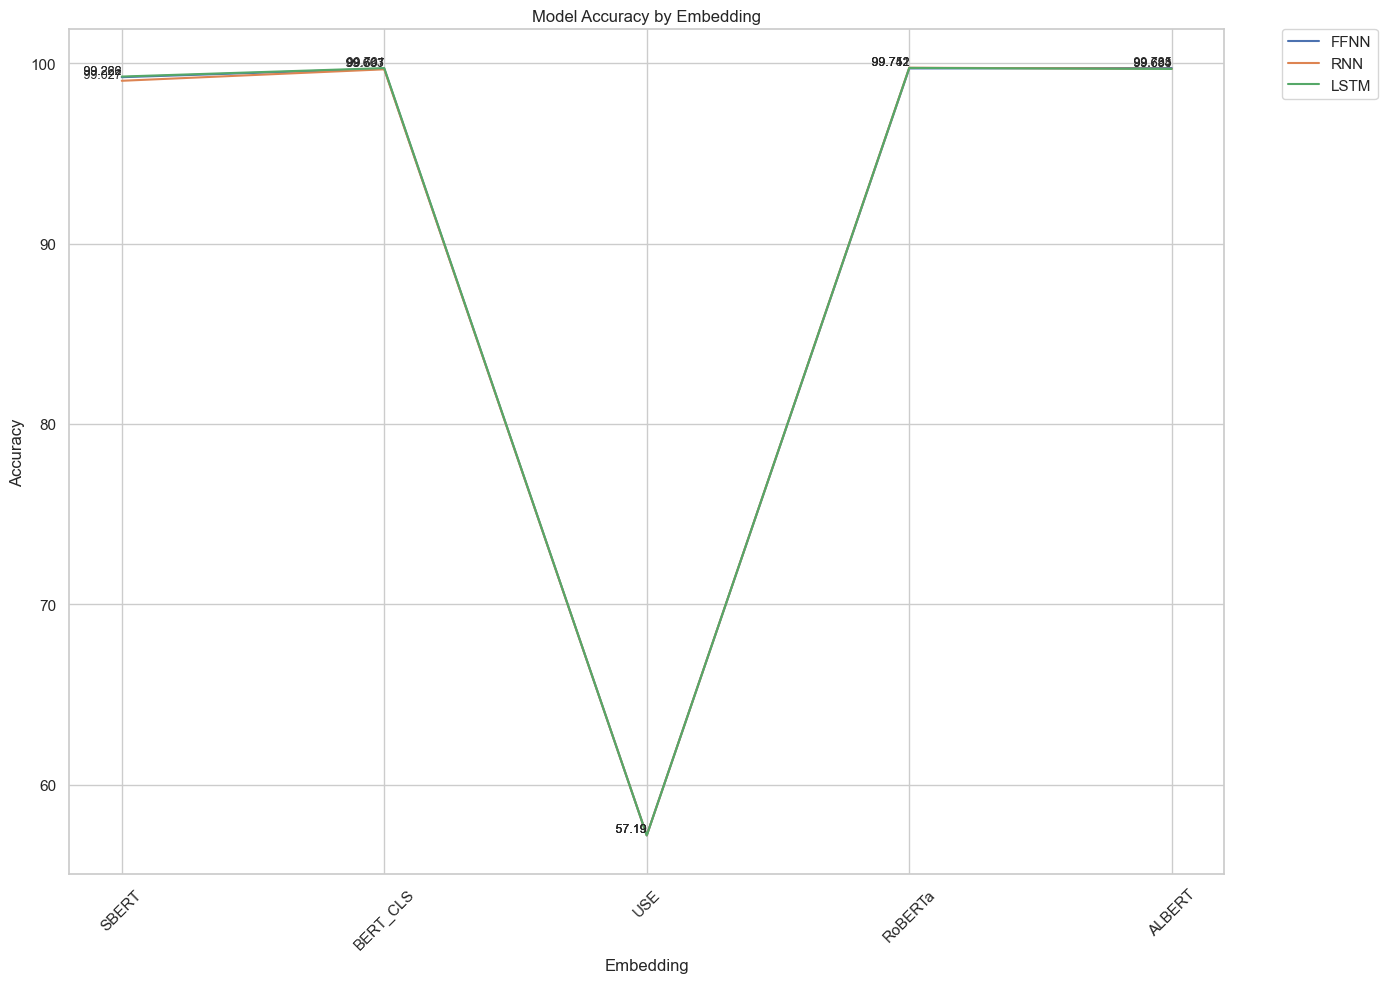

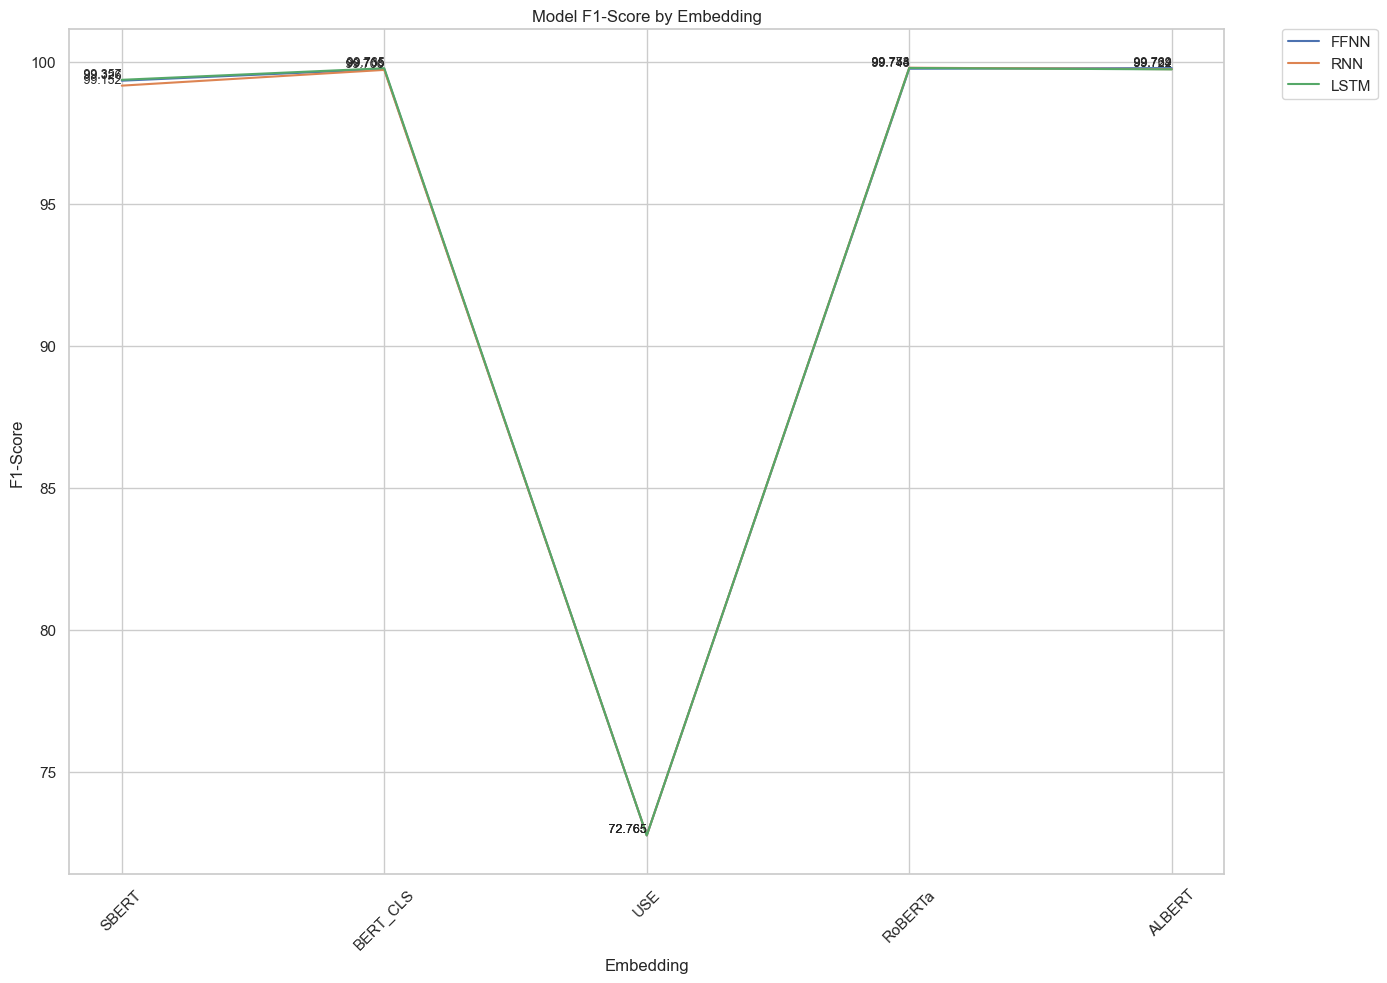

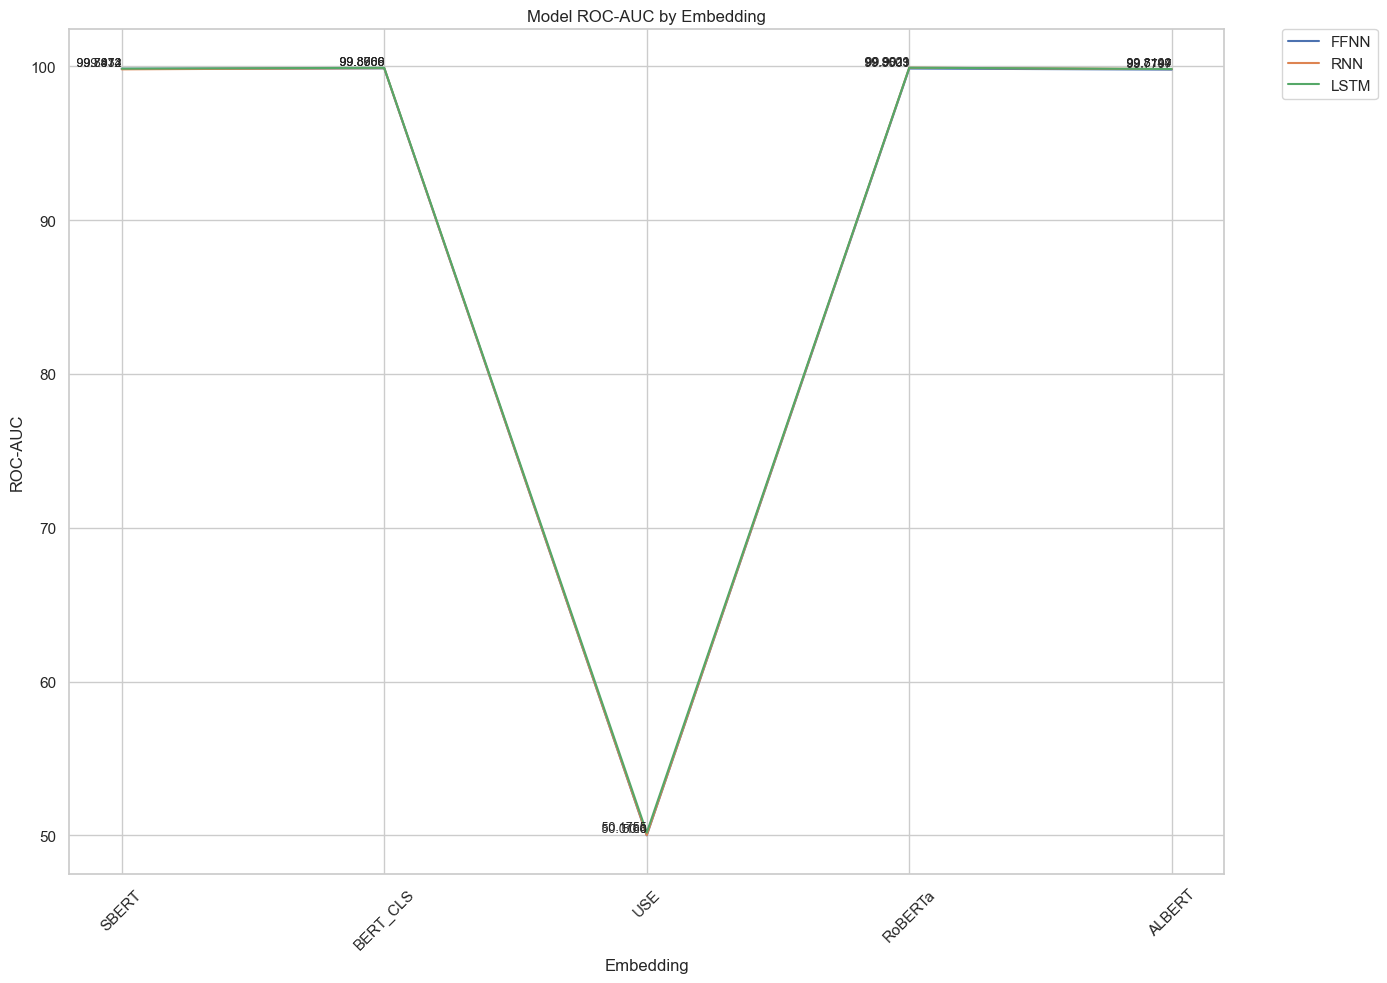

In [58]:
# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Display the results
# print(results_df)

# # Save the results for future reference
# results_df.to_csv('model_embedding_results.csv', index=False)

# # Visualization (as defined earlier)
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="whitegrid")

# # Accuracy
# plt.figure(figsize=(14, 10))
# sns.barplot(x='Embedding', y='Accuracy', hue='Model', data=results_df)
# plt.title('Model Accuracy by Embedding')
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
# plt.show()

# # F1-Score
# plt.figure(figsize=(14, 10))
# sns.barplot(x='Embedding', y='F1-Score', hue='Model', data=results_df)
# plt.title('Model F1-Score by Embedding')
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
# plt.show()

# # ROC-AUC
# plt.figure(figsize=(14, 10))
# sns.barplot(x='Embedding', y='ROC-AUC', hue='Model', data=results_df)
# plt.title('Model ROC-AUC by Embedding')
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
# plt.show()
# Convert results to DataFrame
results_df = pd.DataFrame(results_new)

# Display the results
print(results_df)

# Save the results for future reference
results_df.to_csv('model_embedding_results.csv', index=False)

# Visualization (as defined earlier)
import matplotlib.pyplot as plt
import seaborn as sns
a,b=14,10
sns.set(style="whitegrid")
# Accuracy
plt.figure(figsize=(a, b))
sns.lineplot(x='Embedding', y='Accuracy', hue='Model',markers='o', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['Accuracy'][i], f' {results_df["Accuracy"][i]}', 
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model Accuracy by Embedding')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


# F1-Score
plt.figure(figsize=(14, 10))
sns.lineplot(x='Embedding', y='F1-Score', hue='Model', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['F1-Score'][i], f' {results_df["F1-Score"][i]}', 
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model F1-Score by Embedding')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

# ROC-AUC
plt.figure(figsize=(14, 10))
sns.lineplot(x='Embedding', y='ROC-AUC', hue='Model', data=results_df)
for i in range(len(results_df)):
    plt.text(results_df['Embedding'][i], results_df['ROC-AUC'][i], f' {results_df["ROC-AUC"][i]}',
             fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.title('Model ROC-AUC by Embedding')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

